In [3]:
!pip install -r requirements.txt

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     -- ------------------------------------- 0.2/3.0 MB 5.3 MB/s eta 0:00:01
     ----------- ---------------------------- 0.8/3.0 MB 10.6 MB/s eta 0:00:01
     --------------------------- ------------ 2.1/3.0 MB 15.0 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 17.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/109.8 kB ? eta -:--:--
   ------------------------------------- -- 102.4/109.8 kB ? eta -:--:--
   ---------------------------------------- 109.8/109.8 kB 2.1 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.9-py3-none-

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

class MonteCarloStockPredictor:
    """
    Modelo estocástico basado en el Movimiento Geométrico Browniano (MGB)  
    para la predección de precios futuros de acciones utilizando simulación Monte Carlo.
    """

    def __init__(self, ticker, start_date, end_date, end_prediction_date, num_simulations=10000):
        """
        Parámetros de inicialización del modelo:
        - ticker: símbolo bursátil de la acción (ej. 'AAPL').
        - start_date: fecha de inicio del periodo histórico.
        - end_date: fecha final del periodo histórico.
        - end_prediction_date: fecha final del periodo de predicción.
        - num_simulations: número de trayectorias simuladas (por defecto: 10000).
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.end_prediction_date = end_prediction_date
        self.num_simulations = num_simulations
        self.load_data()
        self.estimate_parameters()

    def load_data(self):
        """Descarga los datos históricos y reales. Calcula los retornos logarítmicos diarios."""
        self.data = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        self.data_real = yf.download(self.ticker, start=self.end_date, end=self.end_prediction_date)
        self.data['Log Returns'] = np.log(self.data['Close'] / self.data['Close'].shift(1))
        self.data.dropna(inplace=True)

    def estimate_parameters(self):
        """Estima el retorno promedio (mu) y la volatilidad (sigma)."""
        self.mu = self.data['Log Returns'].mean() * 252
        self.sigma = self.data['Log Returns'].std() * np.sqrt(252)
        self.S0 = self.data['Close'].iloc[-1]

    def simulate(self):
        """Simula trayectorias futuras del precio usando el modelo de Monte Carlo."""
        T = (pd.to_datetime(self.end_prediction_date) - pd.to_datetime(self.end_date)).days / 252
        dt = 1 / 252
        N = int(T / dt)

        S = np.zeros((N + 1, self.num_simulations))
        S[0] = self.S0

        for t in range(1, N + 1):
            Z = np.random.standard_normal(self.num_simulations)
            S[t] = S[t - 1] * np.exp((self.mu - 0.5 * self.sigma ** 2) * dt + self.sigma * np.sqrt(dt) * Z)

        self.simulated_prices = S

    def plot_simulation(self):
        """Grafica la mediana simulada, el intervalo de confianza y los datos históricos/reales."""
        if not hasattr(self, 'simulated_prices'):
            raise ValueError("Debe ejecutar simulate() antes de graficar.")

        N = self.simulated_prices.shape[0] - 1
        percentiles = np.percentile(self.simulated_prices, [5, 50, 95], axis=1)

        plt.figure(figsize=(14, 7))
        plt.plot(range(-len(self.data), 0), self.data['Close'], color='blue', label='Histórico')
        plt.plot(range(0, len(self.data_real)), self.data_real['Close'], color='green', label='Real')
        plt.plot(range(0, N + 1), percentiles[1], color='red', label='Predicción Mediana')
        plt.fill_between(range(0, N + 1), percentiles[0], percentiles[2], color='gray', alpha=0.3, label="Intervalo 90%")
        plt.title(f'Simulación de Monte Carlo para {self.ticker}', fontsize=18)
        plt.xlabel('Días de Trading', fontsize=16)
        plt.ylabel('Precio de la Acción [USD]', fontsize=16)
        plt.legend(fontsize=14)
        plt.grid()
        plt.show()

    def heat_plot_simulation(self):
        """Genera un mapa de calor de densidad para trayectorias dentro del intervalo 5%-95%."""
        if not hasattr(self, 'simulated_prices'):
            raise ValueError("Debe ejecutar simulate() antes de graficar.")

        N = self.simulated_prices.shape[0] - 1
        percentiles = np.percentile(self.simulated_prices, [5, 50, 95], axis=1)

        plt.figure(figsize=(14, 7))
        plt.plot(range(-len(self.data), 0), self.data['Close'], color='blue', label='Histórico')
        plt.plot(range(0, len(self.data_real)), self.data_real['Close'], color='green', label='Real')
        plt.plot(range(0, N + 1), percentiles[1], color='red', label='Predicción Mediana')
        plt.fill_between(range(0, N + 1), percentiles[0], percentiles[2], color='gray', alpha=0.3, label="Intervalo 90%")

        # Filtrar trayectorias dentro del intervalo 5%-95%
        mask = (self.simulated_prices >= percentiles[0][:, None]) & (self.simulated_prices <= percentiles[2][:, None])
        filtered_prices = self.simulated_prices[mask].flatten()
        filtered_days = np.tile(np.arange(N + 1), self.num_simulations)[mask.flatten()]

        plt.hist2d(filtered_days, filtered_prices, bins=(N + 1, 100), cmap='coolwarm', alpha=0.5)
        plt.colorbar(label="Densidad de Trayectorias")
        plt.title(f'Simulación de Monte Carlo para {self.ticker}', fontsize=18)
        plt.xlabel('Días de Trading', fontsize=16)
        plt.ylabel('Precio de la Acción [USD]', fontsize=16)
        plt.legend(fontsize=14)
        plt.grid()
        plt.show()

    def get_simulation_results(self):
        """Retorna los percentiles 5%, 50% y 95% de la simulación."""
        if not hasattr(self, 'simulated_prices'):
            raise ValueError("Debe ejecutar simulate() antes de obtener los resultados.")

        return np.percentile(self.simulated_prices, [5, 50, 95], axis=1)

    def analyze_volatility(self):
        """Grafica la evolución de la volatilidad a lo largo del tiempo de predicción."""
        volatility = np.std(self.simulated_prices, axis=1)
        plt.figure(figsize=(12, 5))
        plt.plot(volatility, label='Volatilidad simulada', color='purple')
        plt.title('Evolución de la Volatilidad Simulada', fontsize=18)
        plt.xlabel('Días futuros', fontsize=16)
        plt.ylabel('Volatilidad', fontsize=16)
        plt.legend(fontsize=14)
        plt.grid()
        plt.show()

    def evaluate_prediction_accuracy(self):
        """Calcula y muestra el MAE y RMSE comparando mediana simulada con valores reales."""
        real_prices = self.data_real['Close'].values[:len(self.simulated_prices[0])]
        predicted_median = np.percentile(self.simulated_prices, 50, axis=1)[:len(real_prices)]

        mae = np.mean(np.abs(predicted_median - real_prices))
        rmse = np.sqrt(np.mean((predicted_median - real_prices) ** 2))

        print(f"Error Absoluto Medio (MAE): {mae:.2f}")
        print(f"Error Cuadrático Medio (RMSE): {rmse:.2f}")



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


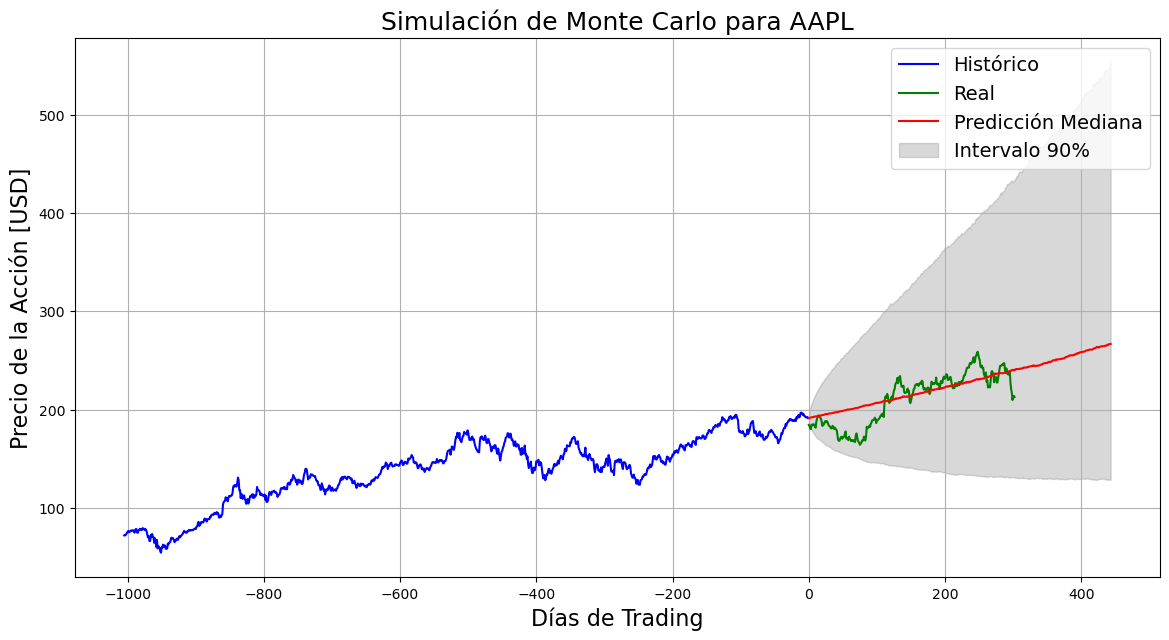

In [5]:
# Crear instancia del predictor
predictor = MonteCarloStockPredictor(
    ticker='AAPL',
    start_date='2020-01-01',
    end_date='2024-01-01',
    end_prediction_date='2025-03-19'
)

# Ejecutar la simulación
predictor.simulate()

# Graficar los resultados
predictor.plot_simulation()

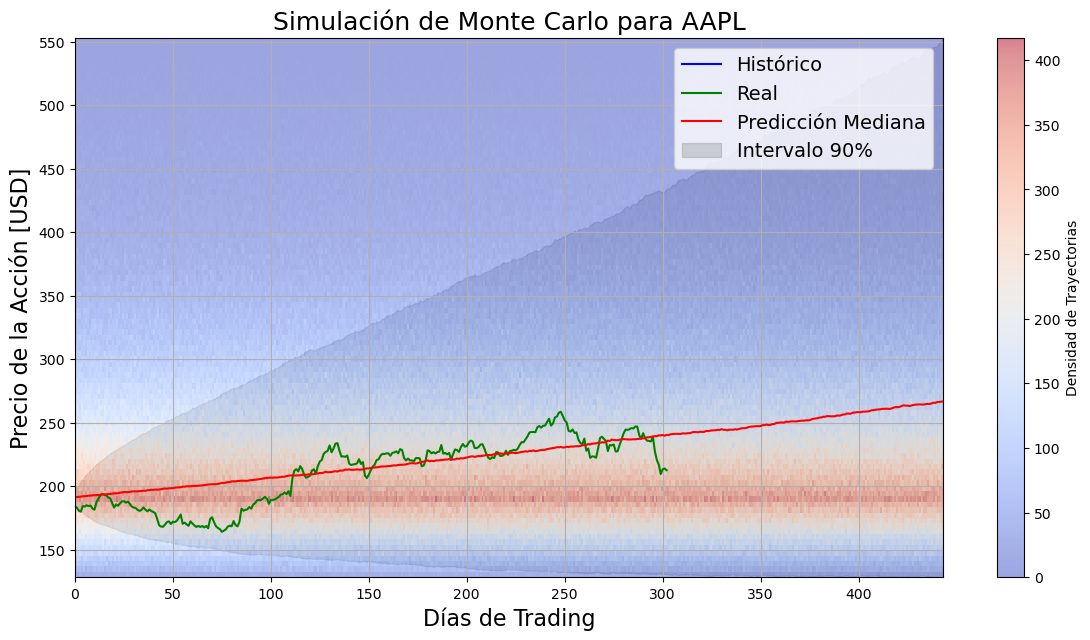

In [6]:
predictor.heat_plot_simulation()

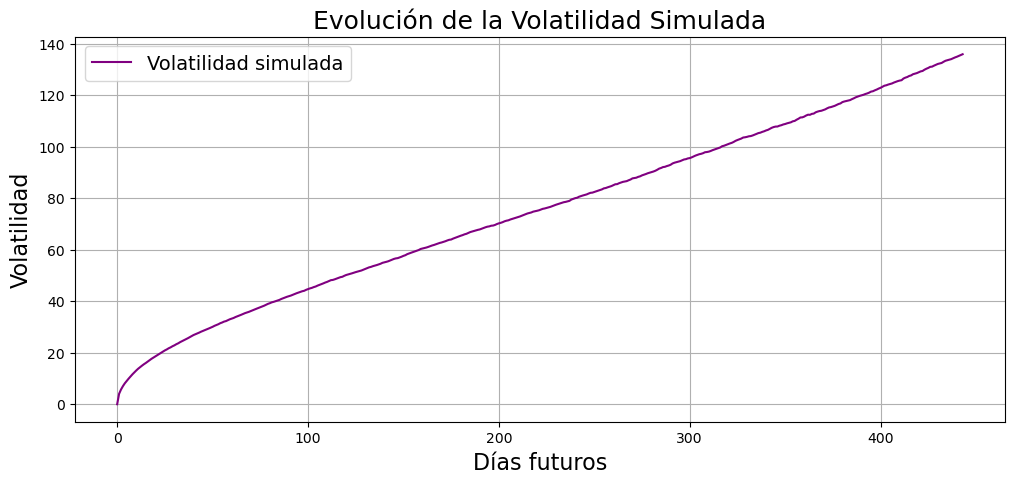

Error Absoluto Medio (MAE): 24.59
Error Cuadrático Medio (RMSE): 29.67


In [7]:
predictor.analyze_volatility()
predictor.evaluate_prediction_accuracy()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


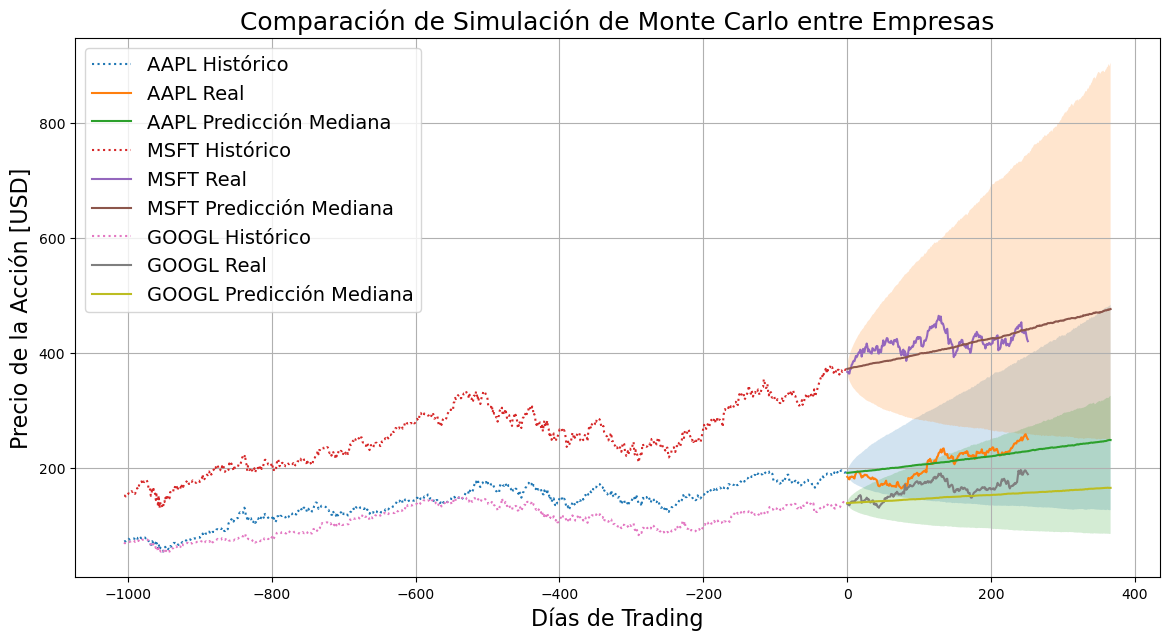

In [8]:
def compare_stocks(tickers, start_date, end_date, end_prediction_date, num_simulations=10000):
    """Compara la simulación Monte Carlo entre diferentes empresas incluyendo datos históricos y reales."""
    plt.figure(figsize=(14, 7))

    for ticker in tickers:
        predictor = MonteCarloStockPredictor(ticker, start_date, end_date, end_prediction_date, num_simulations)
        predictor.simulate()
        percentiles = predictor.get_simulation_results()

        # Graficar los datos históricos
        plt.plot(range(-len(predictor.data), 0), predictor.data['Close'], label=f'{ticker} Histórico', linestyle='dotted')

        # Graficar los datos reales
        plt.plot(range(0, len(predictor.data_real)), predictor.data_real['Close'], label=f'{ticker} Real', linestyle='solid')

        # Graficar la mediana de la simulación y el intervalo de confianza
        plt.plot(range(0, percentiles.shape[1]), percentiles[1], label=f'{ticker} Predicción Mediana')
        plt.fill_between(range(0, percentiles.shape[1]), percentiles[0], percentiles[2], alpha=0.2)

    plt.title('Comparación de Simulación de Monte Carlo entre Empresas',fontsize=18)
    plt.xlabel('Días de Trading',fontsize=16)
    plt.ylabel('Precio de la Acción [USD]',fontsize=16)
    plt.legend(fontsize=14)
    plt.grid()
    plt.show()

# Ejemplo de uso:
compare_stocks(['AAPL', 'MSFT', 'GOOGL'], '2020-01-01', '2024-01-01', '2025-01-01')